<a href="https://colab.research.google.com/github/kiranbirajdar199/CapstoneProject/blob/main/TyresClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

kiranbirajdar199_tyresdata_path = kagglehub.dataset_download('kiranbirajdar199/tyresdata')
kiranbirajdar199_my_model_path = kagglehub.dataset_download('kiranbirajdar199/my-model')

print('Data source import complete.')


In [ ]:
from pathlib import Path
import plotly.express as px
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Define the dataset location
base_dir = Path("/kaggle/input/tyresdata/Digital images of defective and good condition tyres")
newline = "\n"  # Line separator


In [ ]:
# Paths for the defective and good tyres
defective_images_dir = base_dir / "defective"
good_images_dir = base_dir / "good"

# Count images in both categories
defective_count = len(list(defective_images_dir.glob("*")))
good_count = len(list(good_images_dir.glob("*")))

# Display counts
print(newline + "Defective Tyre Count:".ljust(35), f"{defective_count}")
print(newline + "Good Tyre Count:".ljust(35), f"{good_count}")


Defective Tyre Count:               1028

Good Tyre Count:                    828


In [ ]:
# Calculate total and percentages
total_images = defective_count + good_count
defective_ratio = (defective_count / total_images) * 100
good_ratio = (good_count / total_images) * 100

# Plot a bar chart using Plotly
chart = px.bar(
    x=[defective_ratio, good_ratio],
    y=["Defective", "Good"],
    text_auto=".1f",
    title="Tyres Quality Analysis<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Minor Class Imbalance Detected</span>",
    color_discrete_sequence=["#4A4B52"],
    height=300,
    width=850,
)
# Customize the chart aesthetics
chart.update_xaxes(title="Percentage", range=(0, 100))
chart.update_yaxes(title="", categoryorder="total ascending")
chart.update_layout(
    font_color="black",
    title_font_size=18,
    plot_bgcolor="white",
    paper_bgcolor="white",
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    bargap=0.4,
)
chart.show()


Found 1856 files belonging to 2 classes.

Sample Images Preview:


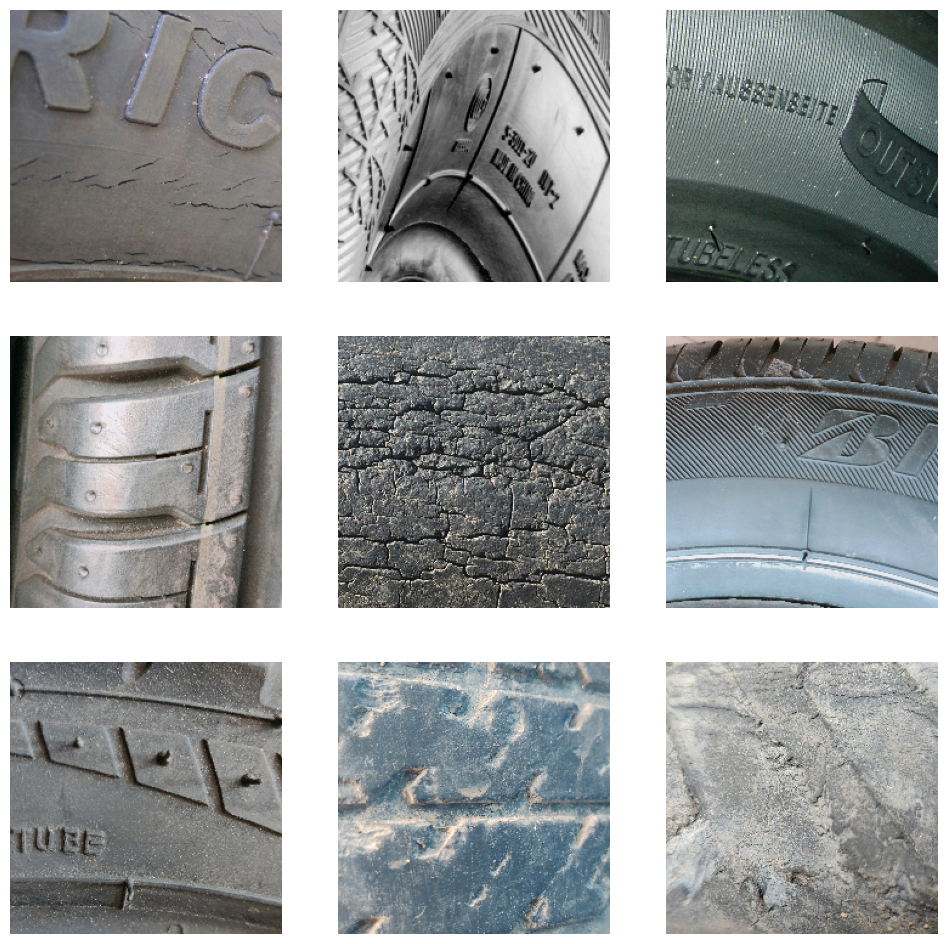

In [ ]:
# Load dataset with Keras
dataset = image_dataset_from_directory(
    base_dir,
    class_names=["defective", "good"],
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    crop_to_aspect_ratio=True,
)

print(newline + "Sample Images Preview:")
sample_batch = list(dataset.take(1).as_numpy_iterator())[0]

# Visualize first 9 images in the batch
plt.figure(figsize=(12, 12))
for idx, (img, lbl) in enumerate(zip(sample_batch[0][:9], sample_batch[1][:9]), 1):
    plt.subplot(3, 3, idx)
    plt.imshow(img.astype(np.int32))
    plt.axis("off")
plt.show()


In [ ]:
# Optimize dataset loading with prefetching
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

# Serialize data into TFRecord files
def save_to_tfrecord(image_paths, labels, output_file, img_size=(224, 224), compression="GZIP"):
    writer_opts = tf.io.TFRecordOptions(compression_type=compression)
    resizer = layers.Resizing(*img_size, crop_to_aspect_ratio=True)

    with tf.io.TFRecordWriter(output_file, writer_opts) as writer:
        for path, label in zip(image_paths, labels):
            img_raw = tf.io.read_file(path)
            img_decoded = tf.io.decode_jpeg(img_raw, channels=3)
            img_resized = resizer(img_decoded)
            img_bytes = tf.io.encode_jpeg(tf.cast(img_resized, tf.uint8)).numpy()

            record = tf.train.Example(
                features=tf.train.Features(
                    feature={
                        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes])),
                        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
                    }
                )
            )
            writer.write(record.SerializeToString())


In [ ]:
# Train-validation split
def split_data(image_dir, val_split=0.2, random_state=None):
    defective_files = glob.glob(str(image_dir / "defective" / "*"))
    good_files = glob.glob(str(image_dir / "good" / "*"))

    all_files = defective_files + good_files
    all_labels = [0] * len(defective_files) + [1] * len(good_files)

    return train_test_split(
        all_files, all_labels, test_size=val_split, random_state=random_state, stratify=all_labels
    )

train_paths, val_paths, train_labels, val_labels = split_data(base_dir, val_split=0.125, random_state=42)
save_to_tfrecord(train_paths, train_labels, "train.tfrecord")
save_to_tfrecord(val_paths, val_labels, "valid.tfrecord")

In [ ]:
# Load data from TFRecord files
def load_tfrecord(file_path, batch_size=32, shuffle=False, cache=True):
    def parse_example(record):
        feature_map = {
            "image": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.int64),
        }
        parsed = tf.io.parse_single_example(record, feature_map)
        img = tf.io.decode_jpeg(parsed["image"], channels=3)
        lbl = parsed["label"]
        return img, lbl

    dataset = tf.data.TFRecordDataset(file_path, compression_type="GZIP")
    dataset = dataset.map(parse_example, num_parallel_calls=AUTOTUNE)
    if cache:
        dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(AUTOTUNE)

In [ ]:

train_ds = load_tfrecord("train.tfrecord", batch_size=32, shuffle=True)
val_ds = load_tfrecord("valid.tfrecord", batch_size=32)


In [ ]:
tf.keras.utils.set_random_seed(42)


In [ ]:
input_layer = layers.Input(shape=(224, 224, 3))
data_aug = keras.Sequential(
    [
        layers.RandomFlip(),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.4),
    ]
)

In [ ]:
base_net = tf.keras.applications.EfficientNetB4(include_top=False, input_shape=(224, 224, 3),weights="/kaggle/input/my-model/efficientnetb4_notop.h5")
global_avg_pooling = layers.GlobalAveragePooling2D()
classifier = layers.Dense(1, activation="sigmoid")

augmented_input = data_aug(input_layer)
feature_maps = base_net(augmented_input)
pooled_features = global_avg_pooling(feature_maps)
output_layer = classifier(pooled_features)

model = keras.Model(inputs=input_layer, outputs=output_layer)

In [ ]:

for layer in base_net.layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])


In [ ]:
# Training the model
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3


2024-12-03 10:19:23.508963: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


     51/Unknown 29s 164ms/step - accuracy: 0.8029 - loss: 0.4142

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 312ms/step - accuracy: 0.8038 - loss: 0.4128 - val_accuracy: 0.8836 - val_loss: 0.2650
Epoch 2/3
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.8838 - loss: 0.2688 - val_accuracy: 0.9009 - val_loss: 0.2848
Epoch 3/3
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.8971 - loss: 0.2437 - val_accuracy: 0.9138 - val_loss: 0.2167


In [ ]:
# Fine-tune specific layers
for layer in base_net.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=2e-4), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2024-12-03 10:20:59.271004: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


51/51 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - accuracy: 0.8747 - loss: 0.2861 - val_accuracy: 0.8922 - val_loss: 0.2326
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.9003 - loss: 0.2317 - val_accuracy: 0.8836 - val_loss: 0.2233
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.9213 - loss: 0.1888 - val_accuracy: 0.9095 - val_loss: 0.2021
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.9205 - loss: 0.1790 - val_accuracy: 0.9310 - val_loss: 0.1847
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.9502 - loss: 0.1349 - val_accuracy: 0.9052 - val_loss: 0.2062
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.9544 - loss: 0.1301 - val_accuracy: 0.9009 - val_loss: 0.2462
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.9417 - loss: 0.1374 - val_accuracy: 0.9095 - val_loss: 0.2204
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.9561 - loss: 0.1172 - val_accuracy: 0.918

In [ ]:
# Evaluate on validation dataset
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.5f}, Validation Accuracy: {val_accuracy:.5f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9300 - loss: 0.1732
Validation Loss: 0.19723, Validation Accuracy: 0.93103


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=32
)


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.9618 - loss: 0.0999 - val_accuracy: 0.9181 - val_loss: 0.1829
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.9724 - loss: 0.0843 - val_accuracy: 0.9224 - val_loss: 0.1567
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.9674 - loss: 0.0914 - val_accuracy: 0.9353 - val_loss: 0.1399
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.9614 - loss: 0.0879 - val_accuracy: 0.9138 - val_loss: 0.1757
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9694 - loss: 0.0861 - val_accuracy: 0.9181 - val_loss: 0.1623
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.9681 - loss: 0.0853 - val_accuracy: 0.9138 - val_loss: 0.1952
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.9644 - loss: 0.0861 - val_accuracy: 0.9224 - val_loss: 0.1721
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.9666 - loss: 0.0971 - val_accu

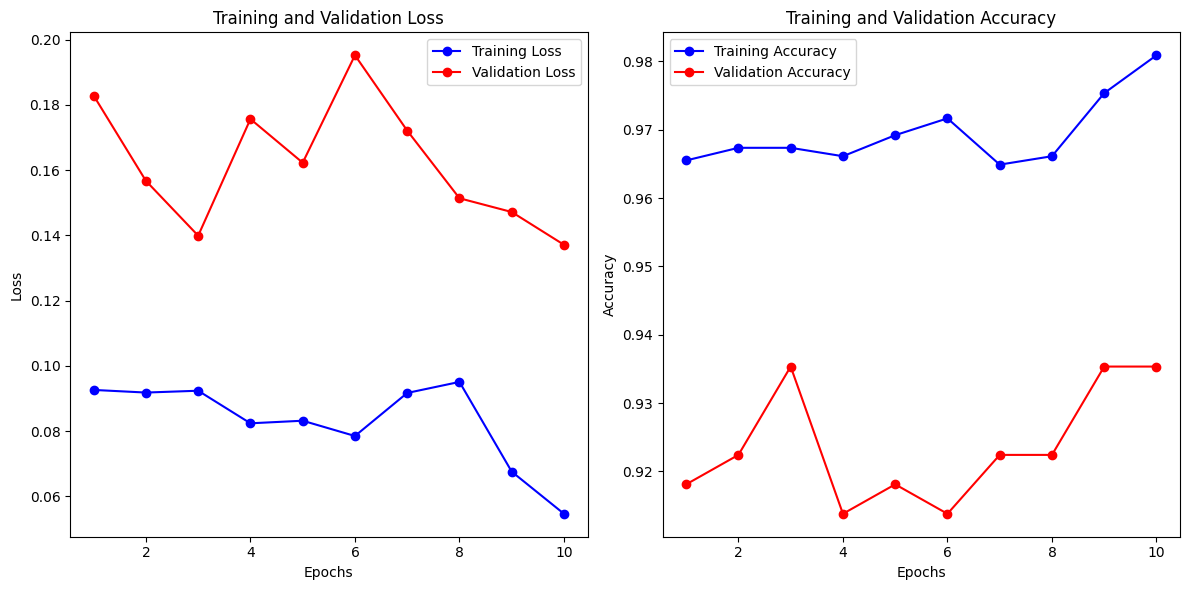

In [ ]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Define epochs
epochs = range(1, len(train_loss) + 1)

# Plot Loss Curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
